In [115]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import timm
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.image as mpimg

In [116]:
class Patch:
    def __init__(self,id :int,x :int,y :int,target :int, path):
        self.id = id;
        self.x = x;
        self.y = y;
        self.target = target;
        self.path = path ;

    #functie pentru a avea valorile pixelilor pentru eventuale procesari
    def imageAsBytes(self):
        with Image.open(self.path) as img:
            return list(img.tobytes());

    

In [117]:
def processImage(path:str):
    atributes = path.split("\\")[-1].split('_')

    id = int(atributes[0])
    x = int(atributes[2][1:])
    y = int(atributes[3][1:])
    target = int(atributes[4][-5])

    result = Patch(id,x,y,target,path);
    return result;


res = processImage('data\8863\\0\8863_idx5_x51_y1251_class0.png')
print(res.imageAsBytes())

[247, 247, 247, 247, 246, 247, 247, 247, 247, 247, 247, 247, 246, 247, 247, 246, 247, 247, 246, 247, 248, 246, 246, 247, 246, 246, 247, 246, 246, 247, 247, 247, 247, 247, 247, 248, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 246, 247, 247, 246, 247, 247, 246, 247, 247, 246, 247, 247, 246, 247, 245, 245, 245, 249, 244, 246, 245, 245, 245, 248, 246, 248, 236, 204, 221, 190, 82, 117, 194, 85, 122, 185, 72, 112, 191, 84, 119, 204, 89, 128, 186, 81, 119, 192, 83, 119, 202, 86, 123, 198, 82, 120, 207, 88, 123, 205, 89, 124, 213, 99, 131, 206, 94, 133, 168, 77, 121, 195, 79, 114, 247, 246, 247, 247, 246, 247, 247, 246, 247, 247, 247, 247, 247, 247, 247, 246, 246, 247, 246, 247, 248, 246, 246, 247, 246, 246, 247, 246, 246, 247, 247, 247, 247, 247, 247, 248, 247, 247, 247, 247, 246, 247, 246, 246, 247, 246, 246, 247, 246, 247, 247, 247, 247,

Numar total de imagini :  276397
Numar total de imagini ce prezinta cancer:  78676  sau  0.28464853091748465 %
Numar total de imagini ce sunt sanatoase :  197721  sau  0.7153514690825153 %

Datele sunt reprezentate de imagini 50x50 pixeli de tesut.
Primele 10 imagini (din primul rand) reprezinta imagini cu tesut ce nu prezinta cancer.
Ultimele 10 imagini (din al doilea rand) reprezinta imagini cu tesut ce prezinta cancer.


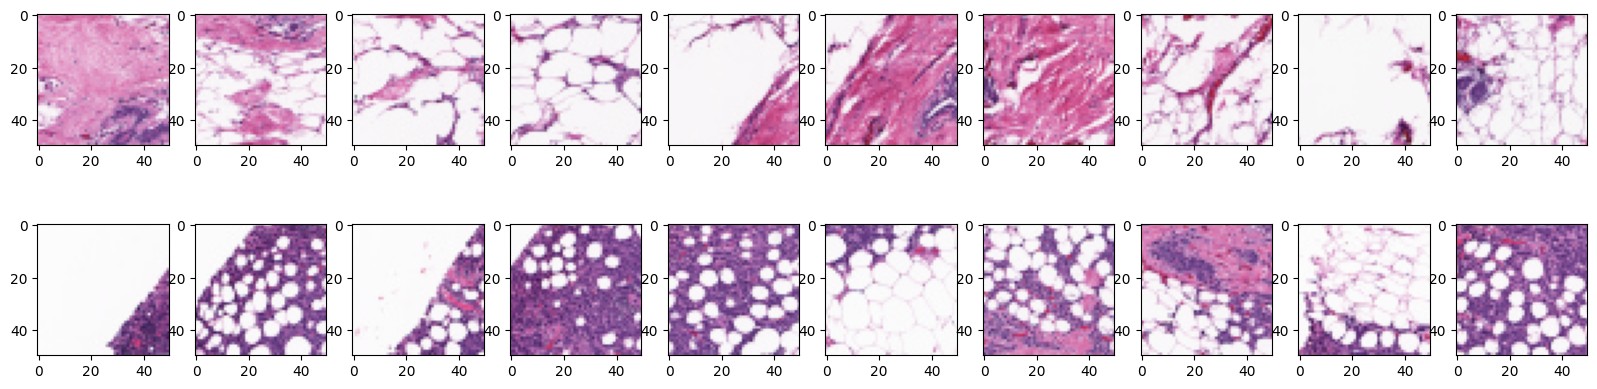

In [118]:
import os

directory = 'data'

patchesT1 = []
patchesT0 = []

for currentDir in os.listdir(directory):
    currentDir = os.path.join(directory,currentDir);
    if currentDir != 'data\IDC_regular_ps50_idx5':
        for class0target in os.listdir(os.path.join(currentDir,'1')):
            fullpath = os.path.join(currentDir,'1',class0target)
            patch = processImage(fullpath);
            patchesT1.append(patch);
        for class0target in os.listdir(os.path.join(currentDir,'0')):
            fullpath = os.path.join(currentDir,'0',class0target)
            patch = processImage(fullpath);
            patchesT0.append(patch);

ill = len(patchesT1);
healthy = len(patchesT0);
total = ill+healthy;

print("Numar total de imagini : " , total)
print("Numar total de imagini ce prezinta cancer: ", ill, " sau ", ill/total , "%")
print("Numar total de imagini ce sunt sanatoase : ", healthy, " sau ", healthy/total, "%")
print();

fig, ax = plt.subplots(2,10,figsize=(20,5))


for m in range(10):
    image = mpimg.imread(patchesT0[m].path)
    ax[0,m].imshow(image)
    ax[0,m].grid(False)
    image = mpimg.imread(patchesT1[m].path)
    ax[1,m].imshow(image)
    ax[1,m].grid(False)

print("Datele sunt reprezentate de imagini 50x50 pixeli de tesut.")
print("Primele 10 imagini (din primul rand) reprezinta imagini cu tesut ce nu prezinta cancer.")
print("Ultimele 10 imagini (din al doilea rand) reprezinta imagini cu tesut ce prezinta cancer.")

In [94]:
# === CONFIG ===
IMG_SIZE = 224 
BATCH_SIZE = 32
EPOCHS = 3
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
print("Se folosește:", DEVICE)

NVIDIA GeForce RTX 3050 Laptop GPU
Se folosește: cuda


In [95]:
# === Dataset custom ===
class MammoDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [96]:
# === 2. Pregătirea datelor ===
def load_data(root='data'):
    all_imgs = []
    labels = []

    for patient in os.listdir('data'):
        if patient == 'IDC_regular_ps50_idx5':
            continue

        patient_dir = os.path.join(root,patient)

        tumor_dir = os.path.join(patient_dir, '1')
        no_tumor_dir = os.path.join(patient_dir, '0')
        
        tumor_imgs = [os.path.join(tumor_dir, f) for f in os.listdir(tumor_dir)]
        no_tumor_imgs = [os.path.join(no_tumor_dir, f) for f in os.listdir(no_tumor_dir)]
        
        all_imgs += tumor_imgs + no_tumor_imgs
        labels += [1]*len(tumor_imgs) + [0]*len(no_tumor_imgs)
    
    return train_test_split(all_imgs, labels, test_size=0.2, random_state=42, stratify=labels)

train_imgs, val_imgs, train_labels, val_labels = load_data()


In [97]:
print(train_imgs[0:3])
print(train_labels[0:3])
print(len(val_imgs),'',len(train_imgs))

['data\\12934\\0\\12934_idx5_x1051_y1951_class0.png', 'data\\9081\\0\\9081_idx5_x2001_y1401_class0.png', 'data\\12749\\1\\12749_idx5_x2601_y1501_class1.png']
[0, 0, 1]
55280  221117


In [98]:
# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = MammoDataset(train_imgs, train_labels, transform)
val_dataset = MammoDataset(val_imgs, val_labels, transform)

In [99]:
# === Oversampling ===
class_counts = np.bincount(train_labels)
weights = 1.0 / class_counts
sample_weights = [weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [100]:
# === Model ViT Small ===
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=2)
model.head = nn.Linear(model.head.in_features, 2)
model.to(DEVICE)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [101]:
# === Antrenare ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
    running_loss = 0.0
    correct, total = 0, 0
    for imgs, labels in train_loader:
        try:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        except Exception as e:
            print(f"[Warning] Skipping batch due to error: {e}",imgs," ",labels)
            continue

    acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/total:.4f} | Accuracy: {acc:.4f}")


Epoch 1/3 | Loss: 0.2538 | Accuracy: 0.8975
Epoch 2/3 | Loss: 0.1959 | Accuracy: 0.9238
Epoch 3/3 | Loss: 0.1588 | Accuracy: 0.9397
